In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.cluster import KMeans
from sklearn import metrics

import os, glob, inspect, sys


currentdir = os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe())))
parentdir = os.path.dirname(currentdir)
sys.path.insert(0,parentdir) 
import epri_mc_lib as mc
from importlib import reload
reload(mc)

<module 'epri_mc_lib' from '/home/marie-anne/code/Oct20_EPRI/Task1/NB/epri_mc_lib.py'>

# Import data

In [8]:
data_path = "../../Data/Merged_data"
df = pd.read_csv(os.path.join(data_path, 'ALL_TUBE_PIPE_simulated.csv'), 
                 index_col=0)
df.head()

,TEP_mean_uV_C,Absorption_avg_500,backscatter_avg,Absorption_avg_50,A,B,p,Absorption_avg_100,Absorption_avg_200,mean_CF,mean_perm,mean_MBN
Condition,,,,,,,,,,,,
T_B1,12.887224,0.000252,0.020317,0.001931,1.202073e-07,0.001092,0.221759,0.000886,0.000301,1.087656,68.832934,0.453917
T_B1,12.904167,0.000194,0.011580,0.001121,2.614525e-08,0.000801,0.214616,0.000605,0.000316,1.094037,67.753088,0.435966
T_B1,12.848012,0.000247,0.027738,0.001309,-3.440295e-07,0.000691,0.173157,0.000556,0.000428,1.098203,67.872952,0.539143
T_B1,12.968064,0.000210,0.019859,0.001921,-5.656336e-07,0.000864,0.213791,0.000746,0.000602,1.117724,65.970169,0.301158
T_B1,12.927068,0.000233,0.013641,0.001425,4.191747e-07,0.000408,0.192750,0.000777,0.000419,1.095836,68.614324,0.472276


## Calculating new values

In [9]:
df['AUC_avg'] = mc.findAUC(df, A=df['A'], B=df['B'], p=df['p'], name='AUC_avg')
df.drop(columns=["A","B","p"],inplace=True)

In [10]:
df['CF_perm'] = df['mean_CF']/df['mean_perm'].astype('float64')
df.drop(columns=["mean_MBN","mean_perm","mean_CF"],inplace=True)

## Scaling values

In [11]:
scaled_df = mc.scale_general(df, MinMaxScaler())[0]
scaled_df.head()

,TEP_mean_uV_C,Absorption_avg_500,backscatter_avg,Absorption_avg_50,Absorption_avg_100,Absorption_avg_200,AUC_avg,CF_perm
Condition,,,,,,,,
T_B1,0.867389,0.240323,0.398567,0.371884,0.448386,0.182419,0.299520,0.076871
T_B1,0.873593,0.184685,0.249685,0.264753,0.355158,0.190679,0.257246,0.079202
T_B1,0.853029,0.235852,0.525029,0.289641,0.338891,0.251385,0.209584,0.079423
T_B1,0.896992,0.199505,0.390772,0.370632,0.402020,0.344953,0.242839,0.084560
T_B1,0.881979,0.222254,0.284809,0.304966,0.412269,0.246211,0.213235,0.078013


## Selecting sub samples

In [12]:
tube, pipe, tube_wo_blind, tube_blind = mc.get_subsample_df(scaled_df)

In [13]:
tube.head()

,TEP_mean_uV_C,Absorption_avg_500,backscatter_avg,Absorption_avg_50,Absorption_avg_100,Absorption_avg_200,AUC_avg,CF_perm
Condition,,,,,,,,
T_B1,0.867389,0.240323,0.398567,0.371884,0.448386,0.182419,0.299520,0.076871
T_B1,0.873593,0.184685,0.249685,0.264753,0.355158,0.190679,0.257246,0.079202
T_B1,0.853029,0.235852,0.525029,0.289641,0.338891,0.251385,0.209584,0.079423
T_B1,0.896992,0.199505,0.390772,0.370632,0.402020,0.344953,0.242839,0.084560
T_B1,0.881979,0.222254,0.284809,0.304966,0.412269,0.246211,0.213235,0.078013


# Clustering

## Elbow method

In [17]:
min_range = 2
max_range = 8

def plot_elbow_kmeans(feat_norm, title):
    '''
    Elbow plot
    Args:
    - feat_norm : pandas dataframe
    - title : title of the figure ideally correpond to the samples
    return plot
    '''
    
    inertia = []
    k_list = range(min_range, max_range+1)

    for k in k_list:
        km = KMeans(n_clusters = k, random_state= 0)
        km.fit(feat_norm) 
        score = km.inertia_
        inertia.append(score)


    plt.figure(1 , figsize = (10 ,6))
    plt.plot(np.arange(min_range , max_range+1) , inertia , 'o')
    plt.plot(np.arange(min_range , max_range+1) , inertia , '-' , alpha = 0.5)

    plt.xlabel('Number of Clusters', fontsize=20) , plt.ylabel('Inertia', fontsize=20)
    plt.title(title, fontsize=20)
    plt.show()

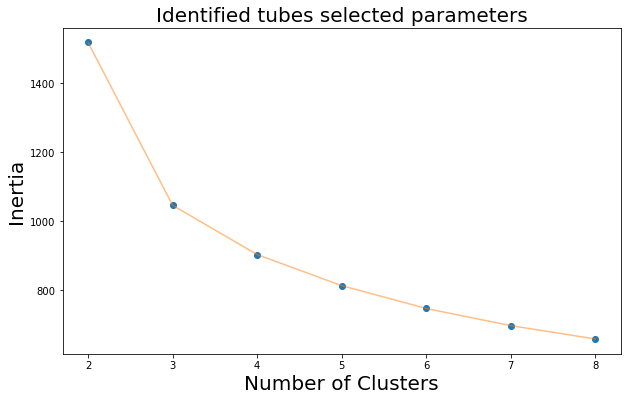

In [18]:
# tubes
plot_elbow_kmeans(tube, title='Tubes simulated')

## Auto find K
Source: https://jtemporal.com/kmeans-and-elbow-method/

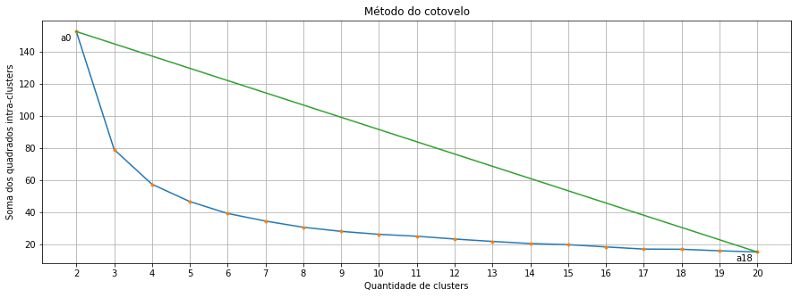

In [19]:
def calculate_wcss(data):
    '''
    Calculate within class sum-squared value which represents loss in KMeans clustering
    '''
    wcss = []
    for n in range(min_range, max_range):
        kmeans = KMeans(n_clusters=n,random_state=0)
        kmeans.fit(data)
        wcss.append(kmeans.inertia_)
    
    return wcss

from math import sqrt

def optimal_number_of_clusters(wcss):
    '''
    Calculate normal distance 
    '''
    x1, y1 = min_range, wcss[0]
    x2, y2 = max_range, wcss[len(wcss)-1]

    distances = []
    for i in range(len(wcss)):
        x0 = i+2
        y0 = wcss[i]
        numerator = abs((y2-y1)*x0 - (x2-x1)*y0 + x2*y1 - y2*x1)
        denominator = sqrt((y2 - y1)**2 + (x2 - x1)**2)
        distances.append(numerator/denominator)
    
    return distances.index(max(distances)) + 2
    

In [21]:
# calculating the within clusters sum-of-squares for n cluster amounts
sum_of_squares = calculate_wcss(tube)
    
# calculating the optimal number of clusters
n = optimal_number_of_clusters(sum_of_squares)
print('Number fo cluster =', n)

Number fo cluster = 4


In [22]:
def plot_kmeans(df, k, range_col):
    '''
    Scatter plot
    Args:
    - df : scaled pandas dataframe
    - range_col : np.r_[range of column wanted]
    return plot
    '''
    model = KMeans(n_clusters = k, random_state= 42)
    model.fit(df) 
    labels = model.predict(df)
    print(labels)
    silhouette = metrics.silhouette_score(df, labels, metric='euclidean')
    print(silhouette)
    df['labels'] = labels
    sns.pairplot(df.iloc[:, range_col], hue='labels')

If the ground truth labels are not known, evaluation must be performed using the model itself. The Silhouette Coefficient (sklearn.metrics.silhouette_score) is an example of such an evaluation, where a higher Silhouette Coefficient score relates to a model with better defined clusters. The Silhouette Coefficient is defined for each sample and is composed of two scores:

    a: The mean distance between a sample and all other points in the same class.
    b: The mean distance between a sample and all other points in the next nearest cluster.

The Silhouette Coefficient s for a single sample is then given as:

s = \frac{b - a}{max(a, b)}

The Silhouette Coefficient for a set of samples is given as the mean of the Silhouette Coefficient for each sample.

    The score is bounded between -1 for incorrect clustering and +1 for highly dense clustering. Scores around zero indicate overlapping clusters.
    The score is higher when clusters are dense and well separated, which relates to a standard concept of a cluster.


In [24]:
tube.shape

(16000, 8)

[0 0 0 ... 0 0 0]
0.40801158585678643


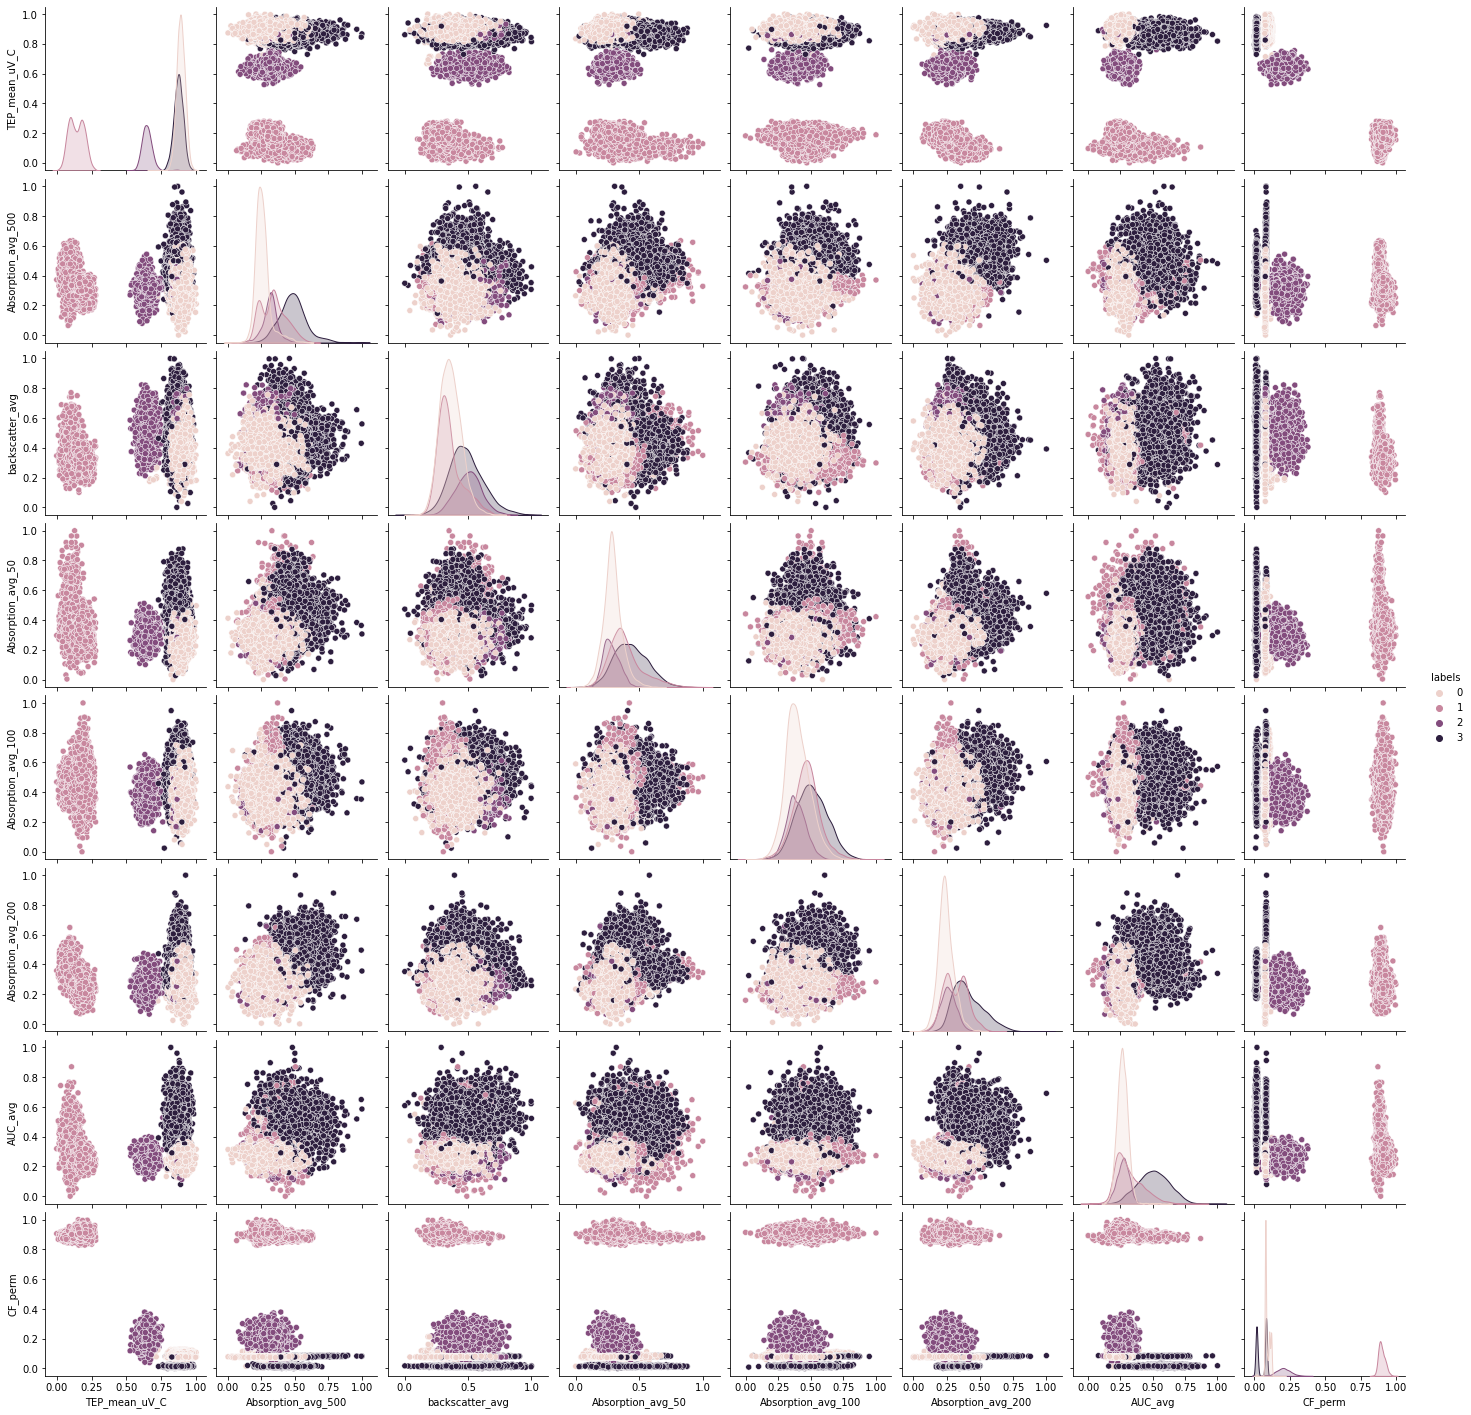

In [27]:
plot_kmeans(tube, 4, np.r_[0:9] )

In [44]:
#test blind sample:
model = KMeans(n_clusters=5, random_state= 42)
model.fit(tube_wo_blind.iloc[:, :]) 
labels = model.predict(tube_wo_blind)
blind_labels = model.predict(tube_blind)

In [49]:
labeled_df = pd.DataFrame()

In [57]:
labeled_df['sample'] = tube_wo_blind.index
labeled_df['labels'] = labels

In [58]:
labeled_df['blind_label'] = blind_labels
labeled_df['blind_sample'] = tube_blind.index

In [63]:
labeled_df.sort_values('labels').drop_duplicates()#.groupby('sample').mean()

,sample,labels,blind_label,blind_sample
2050,T_N_T,0,2,T_B3
5951,T_FF,0,1,T_B6
7360,T_HAZ_T,0,4,T_B8
6016,T_HAZ,1,2,T_B7
6017,T_HAZ,1,0,T_B7
6051,T_HAZ,1,4,T_B7
1374,T_N,1,0,T_B2
1011,T_N,1,2,T_B2
5608,T_FF,2,1,T_B6
4542,T_OT,2,2,T_B5
